In [1]:
using NonLinearDynamicsCourse
using Plots, DifferentialEquations, LinearAlgebra, Polynomials
using BifurcationKit, Setfield, IntervalRootFinding, StaticArrays

# Modelo de saxofon

El modelo esta formado por tres elementos principales:
- un oscilador (no lineal o en aproximacion lineal) de un grado de libertad correspondiente a la lengueta y excitado por la diferencia de presion entre el aire de la boquilla y de la boca del musico (ecuacion de Schumacher)
- Una ecuacion no lineal caracteristica (regularizada) que da el flujo de aire a traves del canal de la lengueta (derivada de la Ecuacion de Bernoulli). Ojo esta no es una ecuacion diferencial sino una ecuacion no lineal algebraica que me vincula el flujo con la diferencia de presion en la boquilla.
- Una descripcion modal de la impedancia del resonador que vincula el flujo con el flujo de aire y la presion (ecuacion de Webster).

Las variables principales del modelo son:

- $x$ : el desplazamiento de la lengueta desde el equilibrio
- $u$ : el flujo de aire entrando en la boquilla
- $p$ : la presion acustica dentro de la boquilla

<div>
<img src="../files/model.png" width="700px">
</div>

En realidad estas variables estan expresadas como magnitudes adimensionales, definidas en funcion de las magnitudes y parametros fisicos del sistema real como:

$x = \large\frac{\hat{x}}{H}$ ;    $u = Z_C\large\frac{\hat{u}}{p_M}$ ;    $p = \large\frac{\hat{p}}{p_M}$ 

donde $H$ es la distancia entre el punto de equilibrio y el tope maximo de oscilacion, $p_M$ es la presion estatica necesaria para llevar la lengueta contra la boquilla y $Z_C$ es la impedancia caracteristica a la entrada del resonador. De esta forma el canal de la lengueta esta cerrado cuando $x<-1$.

Como $u$ no es una variable dinamica independiente, las variables dinamicas de nuestro sistema van a ser:

- $x$ : el desplazamiento de la lengueta desde el equilibrio
- $v$ : la velocidad de la lengueta (necesaria para la descripcion de un oscilador)
- $p_n$ : la presion (compleja) de cada uno de los modos (la presion total sera la suma de las partes reales de las presiones de cada modo)

Es decir para un sistema hiper-simplificado de un modo del tubo tenemos al menos tres ecuaciones diferenciales y luego para $N$ modos del tubo tendremos $N+2$ ecuaciones diferenciales

Los parametros de control son $\gamma$ que se corresponde con la presion de soplado, y $\zeta$ que se corresponde con la fuerza aplicada por el labio para controlar la apertura del canal en el reposo (en realidad expresa la posicion adimensionalizada por H de la lengueta en el reposo) y estan expresados tambien adimensionalmente.

$\gamma = \Large\frac{\hat{\gamma}}{p_M}$ ;     $\zeta = wHZ_c\sqrt{\Large\frac{2}{\rho p_M}}$

donde $w$ es el ancho efectivo de la lengueta, $\hat{\gamma}$ el valor fisico de la presion de soplado y $\rho$ la densidad del aire.

Referencias:
<div class="csl-entry">Colinot, T., Vergez, C., Guillemain, P., &#38; Doc, J. (2021). Multistability of saxophone oscillation regimes and its in fl uence on sound production. <i>Acta Acustica</i>, <i>5</i>(33).</div>
<div class="csl-entry">Colinot, T. (2020). <i>Numerical simulation of woodwind dynamics : investigating nonlinear sound production behavior in saxophone-like instruments Tesis doctoral</i>.</div>
<div class="csl-entry">Bilbao, S. D. (2009). <i>Numerical sound synthesis : finite difference schemes and simulation in musical acoustics (Seccion 9.3)</i>.</div> 

## Modelo de lengueta

La lengueta esta modelada como un oscilador con un solo grado de libertad forzado por la diferencia de presion entre la boquilla y la boca del musico y una no linealidad asociada a la fuerza de contacto entre la lengueta y la boquilla:

El oscilador armonico sin forzar y sin fuerza de contacto seria:

$\dot{x} = v$

$\dot{v} = -q_r\omega_r v - \omega_r^2 x $

Si agregamos el forzado $p - \gamma$ y la fuerza de contacto $F_c$:

$\dot{x} = v$

$\dot{v} = -q_r\omega_r v + \omega_r^2 (p-\gamma - x + F_c(x,v))$

donde $q_r$ es el coeficiente de amortiguacion, $\omega_r$ la frecuencia angular del modo de oscilacion de la lengueta. Para reducir la cantidad de parametros libres podemos asumir: $\omega_r = 4.224$ rad/ms (0.6723 kHz), y $q_r = 1$ 

$F_c(x,v)$ es la fuerza de contacto y se puede modelar como 

$F_c(x,v) = K_c min(x+1,0)^2 (1 − \beta v)$    


donde $K_c=100$ es la rigidez no lineal de la boquilla y $\beta = 1 ms$ el coeficiente de amortiguacion no lineal. Para poca amplitud de oscilacion (valores de $\gamma$ bajos) puede despreciarse esta fuerza (aproximacion "ghost reed")

La funcion $min(x+1,0)$ se puede regularizar como:

$min(x+1,0) \approx \frac{1}{2} x+1-\sqrt{(x+1)^2+\eta}$

Con $\eta$ una constante de regularizacion pequena

In [2]:
# funcion de contacto
function contact(x,v,β,Kc)
    Kc*min(real(x)+1.0,0)^2*(1-β*v)
end    

contact (generic function with 1 method)

In [3]:
# Lengueta sola
function reed_only!(dx,x,p,t)
    β,ω0,Kc,P = p
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
end    

reed_only! (generic function with 1 method)

In [4]:
# definimos parametros como una tupla p
ω0 = 4.224
β = 1
γ = 0.6
Kc = 100
P = 0.0
pars = (β,ω0,Kc,P)
# determinamos el time span y la condicion inicial x0
tspan = (0.0,10)
x0 = [-0.1, 0]
# Definimos el problema pasando la funcion, condicion inicial time span y parametros. 
# Y la resolvemos con el metodo  Tsit5
prob = ODEProblem(reed_only!, x0, tspan, pars)
sol = solve(prob);

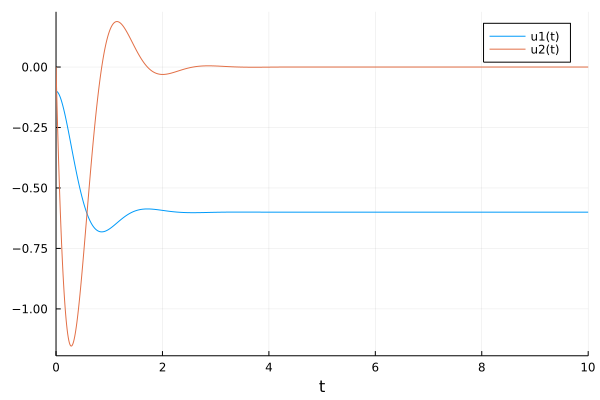

In [5]:
# grafico muy simple de las variables 
plot(sol,vars=1)
plot!(sol,vars=2)

## Modelo del flujo de canal

El flujo total entrando a la boquilla se puede expresar como la suma del flujo debido al movimiento de la lengueta $u_r$ y el flujo a traves del canal $u_b$. Pero la contribucion del primero se puede despreciar.

La aproximacion que se usa es la que da Wilson & Beavers, que se deriva de la Ley de Bernoulli (aproximacion estatica en la que las oscilaciones son pequeñas - numero de Strouhal pequeño). Esta es la figura original del paper )en clarinete) para tener una idea de que es cada cosa:

<div>
<img src="../files/wilson.png" width="300px">
</div>

En este grafico $P$ es la presion de soplado, lo que llamamos $\gamma$ y el area a se puede aproximar como $w \max(\hat{x}+H,0)$ donde $w$ es el ancho del canal y $\max(x+H,0)$ su altura. Una aproximacion importante es que el flujo en la cavidad externa se considera estacionario, es decir la energia es toda potencial: la del soplado. 

La ley de Bernoulli es otra forma de expresar la conservacion de la energia, en este caso tenemos energia potencial dada por la presion estatica y energia cinetica dada por la velocidad del flujo al cuadrado. La planteamos afuera y adentro. Afuera tenemos solo potencial $\gamma$ y adentro tenemos potencial $p$ (la presion en la boquilla) y la velocidad del flujo $U$. Igualando adentro y afuera tenemos

$\frac{1}{2}\rho U^2 + \hat{p} = \hat{\gamma}$

recordar que los sombreros los usamos para las magnitudes fisicas. 

Despejamos $U$ teniendo en cuenta que al sacar la raiz cuadrada tenemos dos soluciones una con signo positivo y otra con signo negativo (de ahi viene la funcion signo)

$U = sign(\hat{\gamma} - \hat{p}) \sqrt{\left| \large\frac{2(\hat{\gamma} - \hat{p})}{\rho}\right|}$

donde $U$ es la velocidad del flujo en la boquilla.

Lo que nos interesa para poder vincular esto con lo que pasa en el tubo es obtener el flujo volumetrico (o caudal) que es lo que se mantiene constante (por continuidad o conservacion de masa). El flujo volumetrico (fisico) $\hat{u}$ es simplemente la velocidad del flujo $U$ multiplicada por el area (seccion del canal) que habiamos dicho
que era $w\max(\hat{x}+H,0)$. Entonces tenemos:

$\hat{u} = w \max(\hat{x}+H,0) sign(\hat{\gamma} - \hat{p}) \sqrt{\left| \large\frac{2(\hat{\gamma} - \hat{p})}{\rho}\right|}$

Vamos a hacer un cambio a las variables adimensionalizadas. Al principio puede marear un poco porque visto todo de seguido la misma ecuacion parece complicarse. Pero como en una trama Hollywoodense al final todo se resuelve y quedamos en una situacion mejor que al principio.

Conviene pensarlo como un juego de reemplazos. Usando las definiciones de las variables adimensionalizadas que escribimos antes vamos reemplazando las variables con sombrero por las variables sin sombrero (adimensionalizadas) y al final todo el lio lo termina absorbiendo la variable adimensionalizada $\zeta$

Haciemos el cambio a variables adimensionalizadas la ecuacion queda:

$u\large\frac{p_M}{Z_c} = \small w H \sqrt{\large\frac{2}{\rho}}\max(x+1,0) sign(\gamma - p) \sqrt{\left|\gamma - p)\right|}$

despejamos $u$ y reordenamos algunos factores

$u = w H Z_c\sqrt{\large\frac{2}{\rho p_M}}\max(x+1,0) sign(\gamma - p) \sqrt{\left|\gamma - p)\right|}$

si reconocemos que lo que esta al principio es la definicion de $\zeta$ nos queda finalmente:

$u = \zeta \max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$

### Regularizacion

Esta funcion de derivada discontinua se puede regularizar tambien haciendo

$\max(x+1,0) \approx \frac{1}{2} x + 1 + \sqrt{(x+1)^2+\eta}$

$|\gamma - p|  \approx \sqrt{(\gamma-p)^2+\eta}$

In [6]:
# funcion de canal (sin regularizar)
function channel(x,p)
    γ,ζ,P = p
    u = ζ*max(real(x)+1,0)*sign(γ-P)*sqrt(abs(γ-P))
end    

channel (generic function with 1 method)

In [7]:
# vamos a variar la presion P y ver cual es la situacion final de equilibrio en x y en u, 
# para eso creamos una lista de valores de P P_list y dos arrays xfin ufin para almacenar los valores finales
γ = 0.3
tmax = 5
dt = 0.05
P_list = γ-1.2:0.001:γ+0.2
ζ = 0.6
xfin =  Array{Float64}(undef, length(P_list))
ufin =  Array{Float64}(undef, length(P_list));

In [8]:
# hacemos un loop sobre los valores de P, resolvemos y almacenamos el ultimo valor de x y calculamos u
for (n,P) in enumerate(P_list)
    p = (β,ω0,Kc,P)
    prob = ODEProblem(reed_only!, x0, tspan, p)
    sol = solve(prob, Tsit5())
    xfin[n] = sol[end][1]
    p1 = (γ,ζ,P)
    ufin[n] = channel(xfin[n],p1)
end    

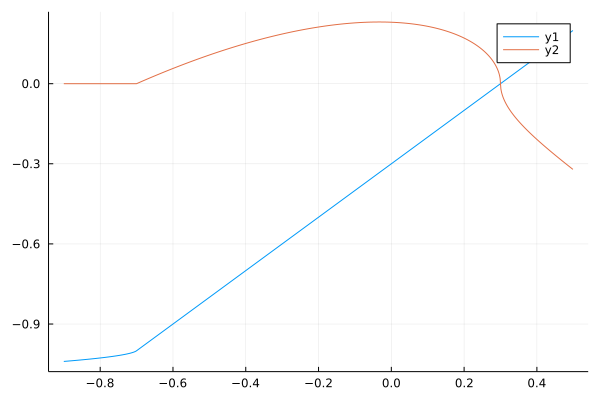

In [9]:
plot(P_list,xfin)
plot!(P_list,ufin)

## Ecuaciones del resonador

La presion en la boquilla y la velocidad del flujo de ntrada estan vinculadas a traves de la impedancia de entrada, que es una funcion de la frecuencia, asi que descompuesto en modos el problema continuo en frecuencia se puede reducir a una ecuacion por cada uno de los $N$ modos activos de oscilacion. En esto si no vamos a entrar en detalle simplemente decir que es una forma de escribir la impedancia compleja $Z(\omega)$ a partir de los residuos y los polos:

$Z(\omega) = \Large\frac{P(\omega)}{U(\omega)} = \sum\limits_{n=0}^{N} \Large\frac{C_n}{i\omega-s_n} + \Large\frac{\bar{C}_n}{i\omega-\bar{s_n}}$

donde $C_n$ y $s_n$ son los residuos y polos complejos de los modos. Los polos se corresponden con los picos de la impedancia, son complejos y se pueden expresar como $s_n = -\alpha_n+j \omega_n$, donde la parte imaginaria $\omega_n$ corresponde a la frecuencia del pico de resonancia y $\alpha>0$ con su ancho. Los residuos se corresponden con la altura de los picos de resonancia. 

La respuesta temporal a un polo complejo es:

$h_n(t) = C_n e^{-\alpha t} e^{j \omega_n t}$

asi por ejemplo de la lista que da Colinot en el ultimo paper de 2021:

<div>
<img src="../files/Modes1.PNG" width="500px">
</div>

podemos ver que el primer polo (pico de resonancia) esta en $\omega_n = 1195$ radianes / segundo, que corresponde a una frecuencia de $f_n = \omega_n/2\pi = 190 Hz$ (un F#, nota escrita D# en el alto)


In [10]:
# PARAMETROS FIJOS EN LO QUE SIGUE PARA EL MODELO DE N MODOS
ωn = [1.195,2.483,3.727,4.405,5.153,6.177,6.749,7.987]
αn = [0.0176,0.0355,0.0653,0.2693,0.0703,0.166,0.0945,0.1165]
Cn = [0.1761,0.4705,0.6494,0.328,0.541,0.2249,0.3822,0.4099]
sn = -αn+1im*ωn
fs = 16.0
dt = 1/fs
Kc = 100.0
ζ = 0.6
β = 1.0
ω0 = 4.224;

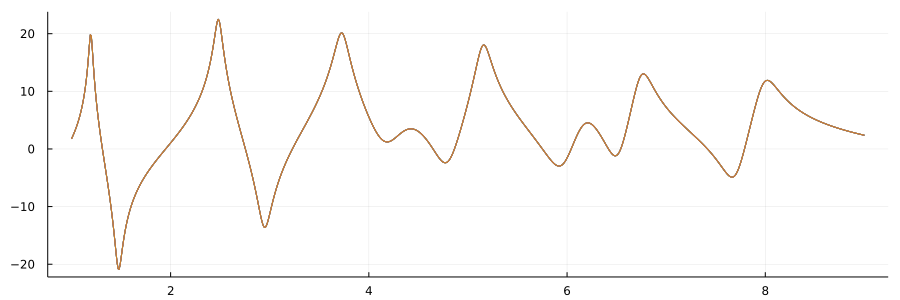

In [11]:
# calculamos la impedancia, notar que aca estamos usando la macro @. que aplica la todas las operaciones 
# sobre arrays elemento a elemento (elementwise) y estamos usando broacasting de un array de (801,8) ω, con
# arrays de (8,) traspuestos (sn y Cn)
ω = repeat(1:0.01:9.0,1,8)
Zs = @. Cn'/(1im*ω-sn')+conj(Cn')/(1im*ω-conj(sn'))
plot(ω,20*log10.(abs.(sum(Zs,dims=2))),size=(900,300),legend=false)

Haciendo la transformada inversa de Fourier de $Z(\omega)$ obtenemos un sistema de N ecuaciones diferenciales ordinarias (pero complejas!). 

Comenzamos descomponiendo $Z(\omega)$ en los n modos y escribiendo cada modo como el cociente entre la presion del modo n y el flujo

$\Large\frac{P_n(\omega)}{U(\omega)} = \frac{C_n}{j\omega-s_n}$

$j\omega P_n(\omega) = s_nP_n(\omega)+C_n u$

Ahora, teniendo en cuenta de que la transformada de Fourier de una funcion armonica tiene como efecto agregar un termino $j\omega$, cuando realizamos la transformada inversa el efecto del factor $j \omega$ es el de introducir la derivada temporal, obteniendo ahora con $p_n(t)$ y $u(t)$ en el dominio del tiempo:

$\dot{p_n}=s_n p_n + C_n u$

con 

$p = 2\sum\limits_{n=1}^{N}Re(p_n)$

# Caso 1 modo. 
Tenemos dos ecuaciones para la lengueta  y una para un modo, lo escribimos de forma explicita

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 (p-\gamma-x+F_c)$

$\dot{p_1} = s_1 p_1 + C_1 u$

con las funciones sin regularizar:

$p=2 Re(p_1)$

$F_c = K_c min(x+1,0)^2 (1 − \beta v)$    

$u = \zeta max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$

In [12]:
function sax!(dx,x,p,t)
    γ,ζ,β,ω0,Kc,s,C = p
    P = 2.0*real(x[3])
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    dx[3] = s*x[3]+C*u
    dx
end

sax! (generic function with 1 method)

In [13]:
γ = 0.48
x0 = [0.18, 0, 0.1+0.4im] 
tspan = (0.0,300)
pars = (γ,ζ,β,ω0,Kc,sn[1],Cn[1])

(0.48, 0.6, 1.0, 4.224, 100.0, -0.0176 + 1.195im, 0.1761)

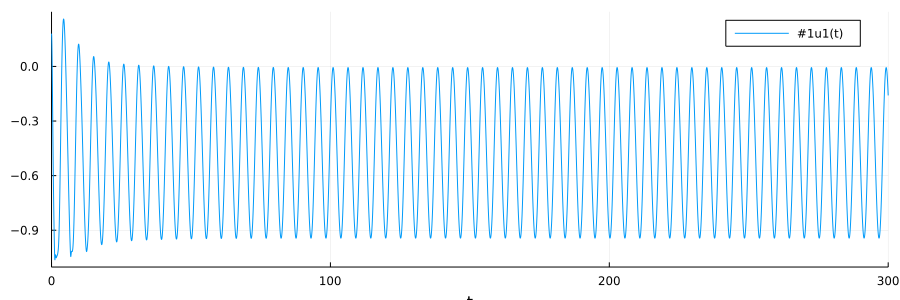

In [14]:
sol = solve(ODEProblem(sax!, x0, tspan, pars));
plot(sol,vars=((t,x) -> (t,real(x)),0,1),size=(900,300))

# Version Real

Si bien derivamos la forma compleja que es mas compacta y es la que esta en el trabajo original de Collinot, la derivada de una funcion compleja (el modo $p_n$) con respecto al tiempo se puede separar en su parte real e imaginaria y lo mismo con el miembro derecho de la ecuacion. La contra es que ahora tendremos dos ecuaciones para cada modo, pero la ventaja es que la mayor parte de las herramientas de calculo numerico (por ejemplo el metodo de Newton y otras que estan en BifurcationKit) estan diseñadas para trabajar con numeros reales. Vamos a escribir nuestra variable de presion compleja como:

$p_n -> p_n/2 + i q_n$

Notar que estamos reutilizando $p_n$ para no vambiar la notacion por lo que de arriba no es una igualdad, ahora $p_n$ es la mitad de la parte real de la presion compleja que podemos renombrar como $\hat{p_n}$. Entonces
de forma mas correcta, si a partir de ahora marcamos con el $\hat{}$ las variables complejas:

$\hat{p_n} = p_n/2 + i q_n$

y la presion total como 

$p = \sum\limits_{n=1}^{N}p_n$

Notar que ahora no esta el factor 2 ni la parte real. Para el caso de un modo simplemente $p=p_1$.
La tercera ecuacion, para el caso de un modo quedaria, reemplazando la derivada y la nueva definicion de la presion como 

$\dot{p_1}/2+ i \dot{q_1} = (-\alpha_n+i\omega_n) (p_1/2+i q_1) + C_1 u(p_1)$

Separando en parte real e imaginaria tenemos ahora dos ecuaciones:

$\dot{p_1}= -\alpha_1 p_1 - 2\omega_1 q_1 + 2C_1 u(p_1)$

$\dot{q_1} = -\alpha_1 q_1 + \omega_n p_1/2$

las dos primeras ecuaciones del sistema no cambian salvo que ahora $p=p_1$ es directamente la tercer variable del sistema de ecuaciones. Escribimos el nuevo sistema de cuatro ecuaciones y comparamos con el resultado anterior para chequear.

In [15]:
function saxR!(dx,x,p,t)
    γ,ζ,β,ω0,Kc,α,ω,C = p
    Fc = Kc*min(x[1]+1,0)^2*(1-β*x[2])
    u = ζ*max(x[1]+1,0)*sign(γ-x[3])*sqrt(abs(γ-x[3]))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(x[3]-γ-x[1]+Fc)
    dx[3] = -α*x[3]-2*ω*x[4]+2*C*u
    dx[4] = -α*x[4]+0.5*ω*x[3]
    dx
end     

saxR! (generic function with 1 method)

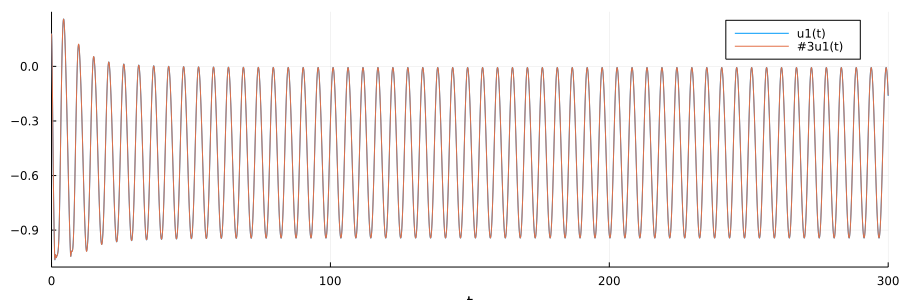

In [16]:
γ = 0.48
x0 = [0.18, 0, 0.2,0.4] 
tspan = (0.0,300)
pars = (γ,ζ,β,ω0,Kc,αn[1],ωn[1],Cn[1])
sol2 = solve(ODEProblem(saxR!, x0, tspan, pars));
plot(sol2,vars=(0,1),size=(900,300))
plot!(sol,vars=((t,x) -> (t,real(x)),0,1))

## Puntos Fijos y Bifurcaciones

Para el caso de un solo modo nos podemos aventurar a calcular los puntos fijos y su estabilidad. Vamos a usar la version real que a pesar de tener una dimension mas va a a facilitar los calculos. De la primera ecuacion  resulta claro que siempre va a corresponder a $v_*=0$ y de la segunda si asumimos $x>-1$ (es decir $F_c=0$) resulta 

$x_* = p_* - \gamma$

Notar que quitamos el subindice 1 del modo para facilitar la notacion. Reemplazando esta expresion en la ecuacion de Bernoulli y asumiendo que $\gamma>P_*$ tenemos la expresion para el flujo en el equilibrio

$u_* = \zeta(p_*-\gamma+1)\sqrt{\gamma-p_*}$

Vamos ahora primero a la cuarta ecuacion que nos da una dependencia directa de $q$ en $p$ para el punto fijo:

$-\alpha_1 q_* + \omega_1 p_*/2 = 0$

mientras que la tercera.

$\alpha_1 \frac{P_*}{2}+\omega_1 q_* = C_1 u_*$

Escribiendo $q_*$ en funcion de $p_*$ y usando la expresion para el flujo escrita anteriormente en la ultima ecuacion nos queda una sola ecuacion con una sola incognita para la presion:

$\left(\alpha_1+\frac{\omega_1^2}{\alpha_1}\right)\frac{p_*}{2}=C_1\zeta(p_*-\gamma+1)\sqrt{\gamma-p_*}$

puede parecer un poco complicada por la raiz pero podemos hacer la sustitiucion $z=\sqrt{\gamma-p}$ (notar que esta variable es igual a la raiz cuadrada del desplazamiento $x$ en valor absoluto. Recordar ademas que esto implica tomar la raiz positiva, vamos a poder sustituir $p_*=\gamma-z^2$. Ademas vamos a juntar todos los parametros en una sola constante:

$A = \frac{1}{2C_1\zeta}\left(\alpha_1+\frac{\omega_1^2}{\alpha_1}\right)$

La ecuacion para la nueva incognita queda escrita entonces como 

$A(\gamma-z^2)=(1-z^2)z$

es una cubica que escrita en la forma canonica queda:

$z^3-Az^2-z+A\gamma=0$

De forma general vamos a tener tres raices, pero en el rango de $\gamma$ que nos interesa una de ellas va a ser negativa (la descartamos porque el cambio de variable tomamos la raiz positiva) y otra con un valor positivo enorme que viola la asuncion $x>-1$.

Vamos a calcular numericamente los puntos fijos para un rango entre $\gamma=0.005$ y $\gamma=1$ que es fisicamente razonable, al menos para que siga siendo valido $x>-1$ y ademas para asegurarnos que $\gamma > p_*$.

In [17]:
# A es una constante
A = (αn[1]+ωn[1]*ωn[1]/αn[1])/(2*Cn[1]*ζ)
B = 0.5*ωn[1]/αn[1]
γ = 0.005:0.001:1.0
rts = roots.([Polynomial([A*g,-1.0,-A,1.0]) for g in γ])
z = getindex.(rts,2)
p0 = γ - z.*z
q0 = 0.5*p0*ωn[1]/αn[1]
x0 = p0 - γ;

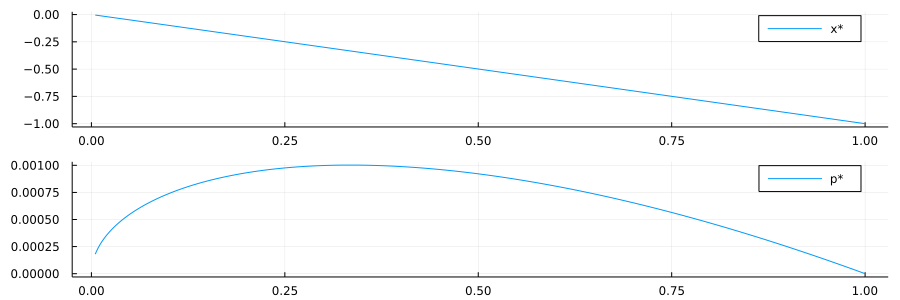

In [18]:
plt0 = plot(γ,x0,label="x*")
plt1 = plot(γ,p0,label="p*")
plot(plt0,plt1,layout=(2,1),size=(900,300))

## Estabilidad del punto Fijo 

El Jacobiano puede escribirse derivando cada ecuacion y asumiendo que en un entorno del punto fijo $x>-1$ y que por lo tanto la derivada de $F_c$ tambien es cero. Considerando $u$ como funcion de $x$ y $p$ podemos escribir primero:

$
\begin{pmatrix}
0 & 1 & 0 & 0\\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0\\
2C_1 \frac{\partial u}{\partial x} & 0 & -\alpha_1+2C_1\frac{\partial{u}}{\partial{p}} & -2\omega_1 \\
0 & 0 & \omega_1/2 & -\alpha_1
\end{pmatrix}
$

Viniendo de sistemas 2D puede intimidar una matriz de 4x4 pero recordar que para el estudio de las bifurcaciones todo lo que tenemos que hacer es calcular los autovalores, que se puede hacer numericamente, y evaluar cuando alguno de ellos cruza el eje imaginario (o sea la parte real se hace cero) o bien cuando un par conjugado cruza el eje imaginario (bifurcacion de Hopf).

Vamos a evaluar en el punto fijo donde $x=p-\gamma$, escribiendo las derivadas en funcion de $p$ y luego en funcion de la raiz del polinomico cubico con la misma sustitucion de antes $z=\sqrt{\gamma-p}$.

La primera derivada puede escribirse:

$\frac{\partial u}{\partial x} = \zeta\sqrt{\gamma-p} = \zeta z$

La segunda

$\frac{\partial{u}}{\partial{p}} = -\zeta \frac{p-\gamma+1}{2\sqrt{\gamma-p}} = - \zeta \frac{1-z^2}{2z} $

Con lo que el Jacobiano en funcion de la nueva variable queda escrito como:

$
\begin{pmatrix}
0 & 1 & 0 & 0 \\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0 \\
2C_1 \zeta z & 0 & -\alpha_1-C_1\zeta \frac{1-z^2}{z} & -2\omega_1 \\
0 & 0 & \omega_1/2 & -\alpha_1
\end{pmatrix}
$

In [19]:
J = [[0 1.0 0 0;-ω0*ω0 -ω0 ω0*ω0 0;2*Cn[1]*ζ*zi 0 -αn[1]-Cn[1]*ζ*(1-zi*zi)/zi -2*ωn[1];0 0 ωn[1]/2 -αn[1]] for zi in z]
λ = [eigen(Ji).values for Ji in J];

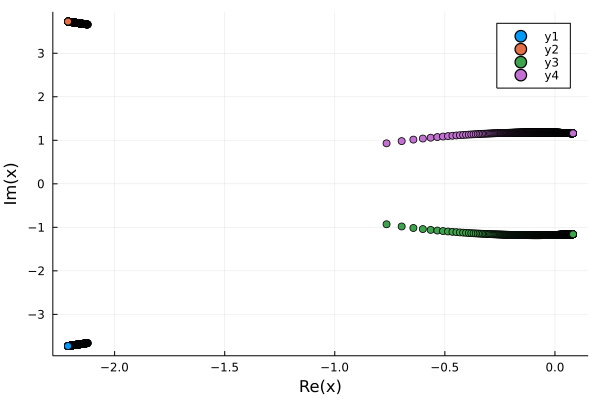

In [20]:
plt1 = plot()
for n=1:4
    scatter!(plt1,getindex.(λ,n))
end    
plt1

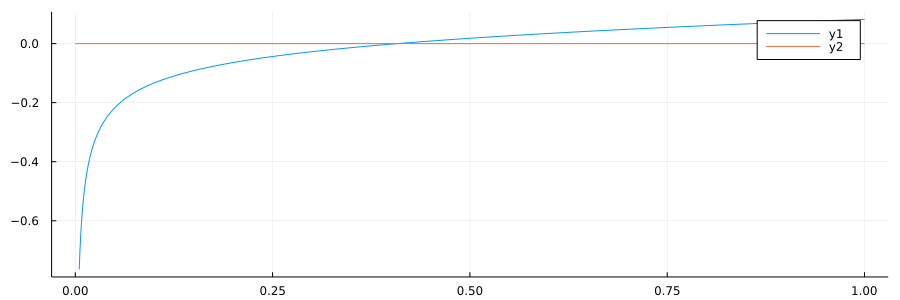

In [21]:
#plot(γ,real(λ3),size=(900,300))
plot(γ,real(getindex.(λ,3)),size=(900,300))
plot!([0,1],[0,0])

In [22]:
nH=findfirst(real(getindex.(λ,3)).>0)
γH=γ[nH]

0.409

In [23]:
n = nH
tspan = (0.0,15000)
p = (γ[n],ζ,β,ω0,Kc,αn[1],ωn[1],Cn[1])
sol1 = solve(ODEProblem(saxR!, [x0[n], 0, p0[n], q0[n]+0.001], tspan, p));
plt1 = plot(sol1,vars=(0,1),label=γ[n])
p = (γ[n-1],ζ,β,ω0,Kc,αn[1],ωn[1],Cn[1])
sol2 = solve(ODEProblem(saxR!, [x0[n-1], 0, p0[n-1], q0[n-1]+0.001], tspan, p));
plt2 = plot(sol2,vars=(0,1),label=γ[n-1])
p = (γ[n-2],ζ,β,ω0,Kc,αn[1],ωn[1],Cn[1])
sol3 = solve(ODEProblem(saxR!, [x0[n-2], 0, p0[n-2], q0[n-2]+0.001], tspan, p));
plt3 = plot(sol3,vars=(0,1),label=γ[n-2])
plot(plt1,plt2,plt3,layout=(3,1),size=(900,300))

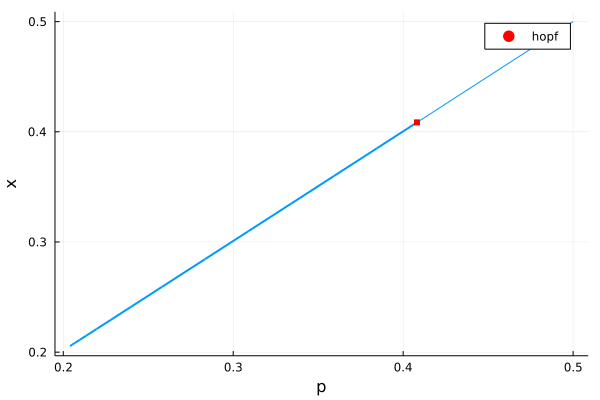

In [24]:
n = 200
saxr(u,p) = saxR!(similar(u),u,p,0)
p = (γ[n],ζ,β,ω0,Kc,αn[1],ωn[1],Cn[1])
opts = ContinuationPar(pMin=γ[n],pMax=0.5, ds = 0.001, dsmax = 0.02,detectBifurcation=3,nInversion=8)
br1, = continuation(saxr,[x0[n], 0, p0[n], q0[n]],p,(@lens _[1]), opts)
plot(br1)

In [25]:
br1.specialpoint[1]

BifurcationKit.SpecialPoint{Float64, NamedTuple{(:x,), Tuple{Float64}}, Vector{Float64}}
  type: Symbol hopf
  idx: Int64 15
  param: Float64 0.4081448100819995
  norm: Float64 0.40853190039421394
  printsol: NamedTuple{(:x,), Tuple{Float64}}
  x: Array{Float64}((4,)) [-0.4071597939186012, 0.0, 0.0009850161633982927, 0.03344017941082272]
  τ: BorderedArray{Vector{Float64}, Float64}
  ind_ev: Int64 2
  step: Int64 14
  status: Symbol guessL
  δ: Tuple{Int64, Int64}
  precision: Float64 7.719524325877636e-7
  interval: Tuple{Float64, Float64}


# N modos version compleja

Ahora tenemos dos ecuaciones para la lengueta  y N ecuaciones complejas para los modos

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 (p-\gamma-x+F_c)$

$\dot{p_n} = s_n p_n + C_n u$

con las funciones (por ahora) sin regularizar:

$p=2 \sum\limits_{n=1}^{N} Re(p_n)$

$F_c = K_c min(x+1,0)^2 (1 − \beta v)$    

$u = \zeta max(x+1,0)sign(\gamma-p)\sqrt{|\gamma-p|}$


In [26]:
function saxN!(dx,x,p,t)
    γ,ζ,β,ω0,Kc,s,C = p
    P = 2.0*sum(real.(x[3:end]))
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    for n=3:length(x)
        dx[n] = s[n-2]*x[n]+C[n-2]*u
    end    
end

saxN! (generic function with 1 method)

In [27]:
# solo definimos los parametros que cambian en el problema: la presion de soplado γ y la cantidad de modos
# la condicion inicial es con x en -γ y todos los modos en 0
γ0 = 0.405
nmodes = 8
xini = vcat([-γ0, 0],repeat([0.0+0.001im],nmodes))
tspan = (0.0,500)
pars = (γ0,ζ,β,ω0,Kc,sn,Cn);

In [28]:
prob = ODEProblem(saxN!, xini, tspan, pars)
sol = solve(prob,saveat=dt);

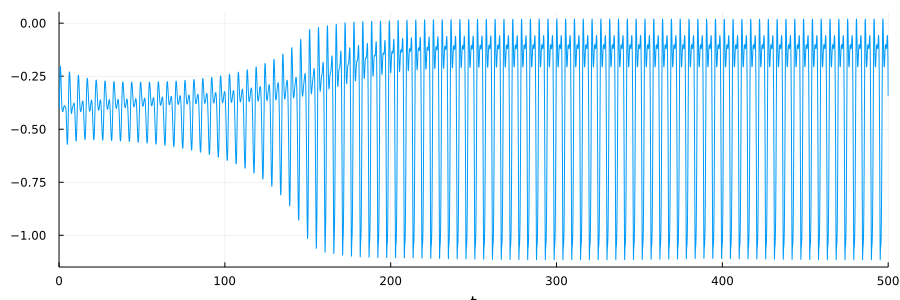

In [29]:
plot(sol,vars=((t,x) -> (t,real(x)),0,1),size=(900,300),legend=false)

# N modos version real

Ahora vamos a tener dos ecuaciones para la lengueta  y 2N ecuaciones reales para los modos

$\dot{x} = v$

$\dot{v} = -\omega_r v + \omega_r^2 \left(\sum p_n -\gamma-x+F_c(x,v) \right)$

$\dot{p_n} = -\alpha_n p_n -2\omega_n q_n + 2C_n u\left(x, \sum p_n \right)$

$\dot{q_n} = -\alpha_n q_n + \omega_n p_n/2$

donde pusimos la dependencia la suma sobre las presiones de cada modo forma explicita y las funciones (sin regularizar):

$F_c(x,v) = K_c min(x+1,0)^2 (1 − \beta v)$    

$u\left(x, \sum p_n \right) = \zeta max(x+1,0)sign\left( \gamma-\sum p_n \right)\sqrt{\left|\gamma-\sum p_n\right|}$


In [30]:
function saxRN!(dx,x,p,t)
    γ,ζ,β,ω0,Kc,α,ω,C = p
    P = sum(x[3:2:end])
    Fc = Kc*min(real(x[1])+1,0)^2*(1-β*x[2])
    u = ζ*max(real(x[1])+1,0)*sign(γ-P)*sqrt(abs(γ-P))
    dx[1] = x[2]
    dx[2] = -ω0*x[2]+ω0^2*(P-γ-x[1]+Fc)
    for n=3:2:length(x)
        m = (n-1)÷2
        dx[n] = -α[m]*x[n]-2*ω[m]*x[n+1]+2*C[m]*u
        dx[n+1] = -α[m]*x[n+1]+0.5*ω[m]*x[n]
    end
    dx
end

saxRN! (generic function with 1 method)

In [31]:
γ0 = 0.405
nmodes = 8
xini = vcat([-γ0, 0],repeat([0.0,0.001],nmodes))
tspan = (0.0,500)
pars = (γ0,ζ,β,ω0,Kc,αn,ωn,Cn);

In [32]:
prob = ODEProblem(saxRN!, xini, tspan, pars)
sol2 = solve(prob,saveat=dt);

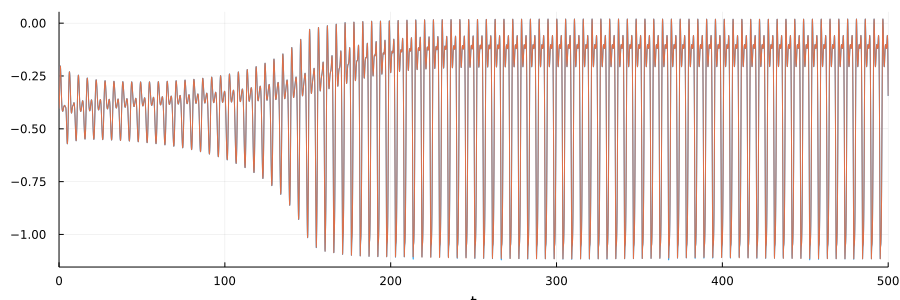

In [33]:
plot(sol2,vars=(0,1),size=(900,300),legend=false)
plot!(sol,vars=((t,x) -> (t,real(x)),0,1))

## Puntos fijos

In [34]:
function fixedpoints(γ,ζ,α,ω,C)
    An = @. (α+ω*ω/α)/(2.0*C*ζ)
    function fsv(pn)
        p = sum(pn)
        dp = @. An*pn-(p-γ+1)*sqrt(γ-p)
        return SVector{length(dp),typeof(dp[1])}(dp)
    end  
    X = -0.01..0.01
    rts = roots(fsv, X × X × X × X × X × X × X × X)
    p0=mid(rts[1].interval)
end    

fixedpoints (generic function with 1 method)

In [35]:
γ = 0.2:0.01:0.9
p0 = fixedpoints.(γ,ζ,(αn,),(ωn,),(Cn,))
q0 = [0.5*pi.*ωn./αn for pi in p0]
P0 = [sum(pi) for pi in p0]
x0 = P0 - γ;

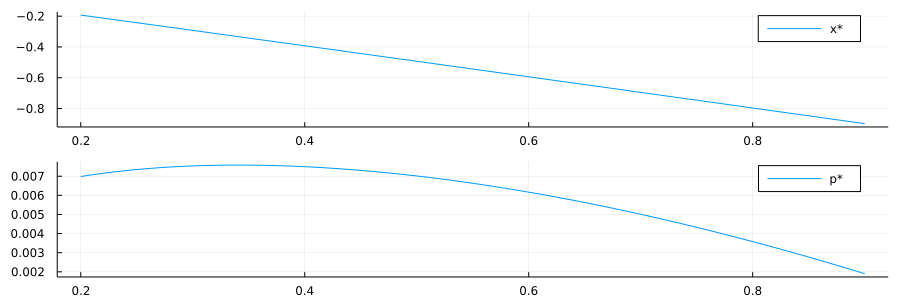

In [36]:
plt0 = plot(γ,x0,label="x*")
plt1 = plot(γ,P0,label="p*")
plot(plt0,plt1,layout=(2,1),size=(900,300))

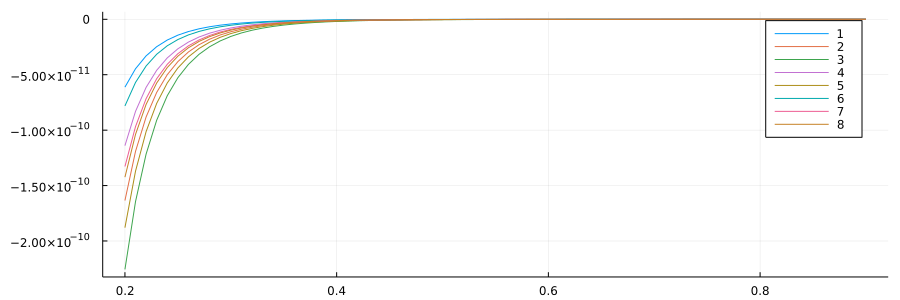

In [37]:
nmodes = 8
saxrn(u,p) = saxRN!(similar(u),u,p,0)
pf = [vcat([x0[n],0],vec([p0[n] q0[n]]')) for n=1:length(x0)]
pars = [(γi,ζ,β,ω0,Kc,αn,ωn,Cn) for γi in γ]
dpf = saxrn.(pf,pars)
plt1 = plot(size=(900,300))
for n=1:8
    plot!(plt1,γ,getindex.(dpf,2*n+1),label=n)
end
plt1

## Estabilidad

$
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & ...\\
-\omega_r^2 & -\omega_r & \omega_r^2 & 0 & \omega_r^2 & 0 & \omega_r^2 & 0 & \dots\\
2C_1\zeta z & 0 & -\alpha_1-C_1\zeta\frac{1-z^2}{z} & -2\omega_1 & -C_1\zeta\frac{1-z^2}{z} & 0& -C_1\zeta\frac{1-z^2}{z} & 0 & \dots\\
0 & 0 & \omega_1/2 & -\alpha_1 & 0 & 0 & 0 & 0 & \dots\\
2C_2\zeta z & 0 & -C_2\zeta\frac{1-z^2}{z} & 0 & -\alpha_2-C_2\zeta\frac{1-z^2}{z} & -2\omega_2 & -C_2\zeta\frac{1-z^2}{z} & 0 & \dots\\
0 & 0 & 0 & 0 & \omega_2/2 & -\alpha_2 & 0 & 0 & \dots\\
2C_3\zeta z & 0 & -C_3\zeta\frac{1-z^2}{z} & 0 & -C_3\zeta\frac{1-z^2}{z} & 0 & -\alpha_3-C_3\zeta\frac{1-z^2}{z} & -2\omega_3 & \dots\\    
0 & 0 & 0 & 0 & 0 & 0 & \omega_3/2 & -\alpha_3 & \dots  \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
$



In [38]:
function JsaxRn0(p,p0)
    γ,ζ,β,ω0,Kc,α,ω,C = p
    z = sqrt(γ-p0)
    nmodes = length(α)
    J0 = zeros(Float64,(2*(nmodes+1),2*(nmodes+1)))
    J0[1,2] = 1.0
    J0[2,1] = -ω0*ω0
    J0[2,2] = -ω0
    J0[2,3:2:2*nmodes+1] .= ω0*ω0
    for n=1:nmodes
        J0[2*n+1,1] = 2*C[n]*ζ*z
        J0[2*n+1,3:2:2*nmodes+1] .= -C[n]*ζ*(1-z*z)/z
        J0[2*n+1,2*n+1] += -α[n]
        J0[2*n+2,2*n+2] = -α[n]
        J0[2*n+1,2*n+2] = -2*ω[n]
        J0[2*n+2,2*n+1] = ω[n]/2.0
    end
    J0
end    

JsaxRn0 (generic function with 1 method)

In [39]:
pv = [(γi,ζ,β,ω0,Kc,αn,ωn,Cn) for γi in γ];
J0 = JsaxRn0.(pv,P0)
λ = [eigen(Ji).values[sortperm(imag(eigen(Ji).values),by=abs)] for Ji in J0];

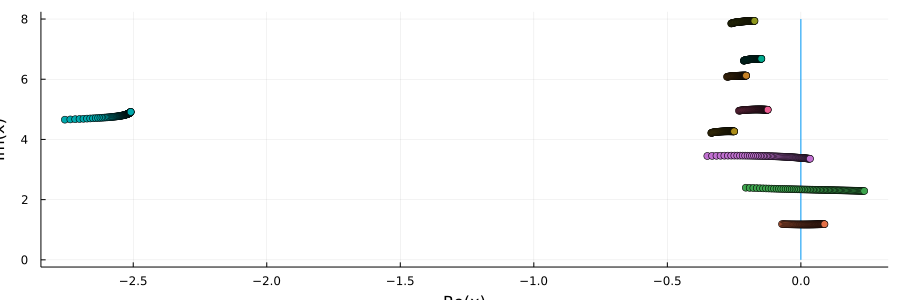

In [40]:
plt1 = plot([0,0],[0,8],legend=false,size=(900,300))
for n=1:9
    #scatter!(plt1,getindex.(λ,2*n-1))
    scatter!(plt1,getindex.(λ,2*n))
end    
plt1

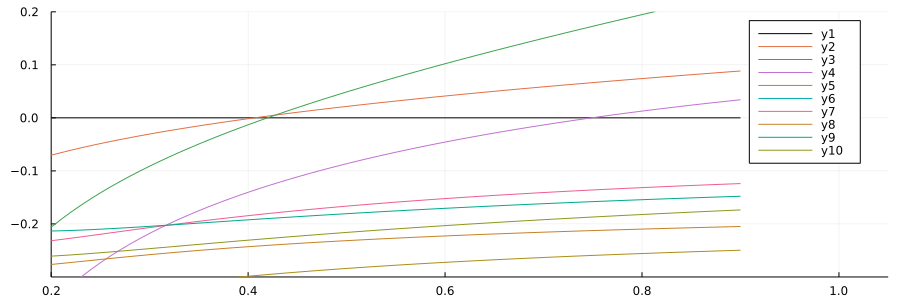

In [41]:
plt1 = plot([0.2,0.9],[0,0],color=:black,size=(900,300),xlims=(0.2,1.05),ylims=(-0.3,0.2))
for n=1:2:18
    plot!(plt1,γ,getindex.(real.(λ),n))
end    
plt1

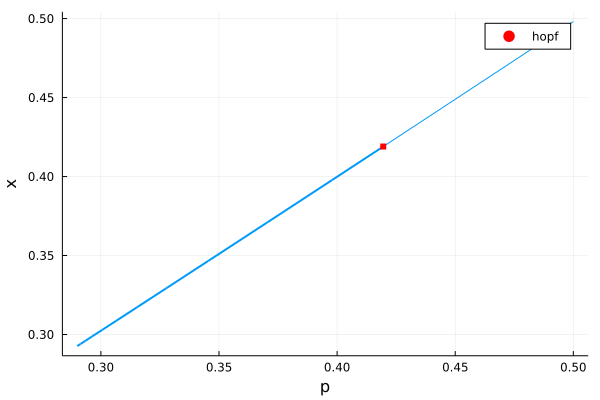

In [42]:
n = 10
saxrn(u,p) = saxRN!(similar(u),u,p,0)
p = (γ[n],ζ,β,ω0,Kc,αn,ωn,Cn)
opts = ContinuationPar(pMin=γ[n],pMax=0.5, ds = 0.001, dsmax = 0.02,detectBifurcation=3,nInversion=8)
br1, = continuation(saxrn,pf[n],p,(@lens _[1]), opts)
plot(br1)

In [43]:
br1.specialpoint[1]

BifurcationKit.SpecialPoint{Float64, NamedTuple{(:x,), Tuple{Float64}}, Vector{Float64}}
  type: Symbol hopf
  idx: Int64 12
  param: Float64 0.4195404367473303
  norm: Float64 0.419003641739101
  printsol: NamedTuple{(:x,), Tuple{Float64}}
  x: Array{Float64}((18,)) [-0.4121056374629156, 0.0, 0.0009827133093273327, 0.03336200013199325, 0.0012266780549633584, 0.04289917761231014, 0.0013821596206604714, 0.03944340663247762, 0.002053917723247693, 0.016798194524519285, 0.0006485393049973839, 0.023769011654704967, 0.0004428061290582938, 0.008238594756605664, 0.0003590403973123724, 0.012820971647942863, 0.00033894474484786734, 0.011618676725750714]
  τ: BorderedArray{Vector{Float64}, Float64}
  ind_ev: Int64 4
  step: Int64 11
  status: Symbol guessL
  δ: Tuple{Int64, Int64}
  precision: Float64 8.399539970782577e-7
  interval: Tuple{Float64, Float64}
